## 3. Tree Classification Models


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from functools import reduce
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [ ]:
# File paths for 2015-2016 data
blood_pressure_path= "./Data/BPX_I.XPT"
demographic_path= "./Data/DEMO_I.XPT"
dietary_path = "./Data/DR1TOT_I.XPT"
body_measures_path = "./Data/BMX_I.XPT"
physical_path = "./Data/PAQ_I.XPT"
physical = pd.read_sas(physical_path)
blood_pressure = pd.read_sas(blood_pressure_path)
demographic = pd.read_sas(demographic_path)
dietary = pd.read_sas(dietary_path)
body_measures = pd.read_sas(body_measures_path)

In [ ]:
#Dependent Variables
patient='SEQN'
age = 'RIDAGEYR'
gender = 'RIAGENDR'
systolic_2nd_reading='BPXSY2'
diastolic_2nd_reading = 'BPXDI2'
systolic_3rd_reading='BPXSY3'
diastolic_3rd_reading = 'BPXDI3'
calcium = 'DR1TCALC'
phosphore = 'DR1TPHOS'
magnesium = 'DR1TMAGN'
iron = 'DR1TIRON'
zinc = 'DR1TZINC'
copper = 'DR1TCOPP'
sodium = 'DR1TSODI'
potassium = 'DR1TPOTA'
selenium = 'DR1TSELE'
sugar = 'DR1TSUGR'
caffeine = 'DR1TCAFF'
fat = 'DR1TTFAT'
weight = 'BMXWT'
height = 'BMXHT'
bmi = 'BMI'
activity = 'PAQ620'
race = 'RIDRETH1'
income = 'INDHHIN2'

In [ ]:
# Create a merged data frame of patients characteristics
cm_blood_pressure = blood_pressure.drop(blood_pressure.columns.difference([patient,systolic_2nd_reading, diastolic_2nd_reading, systolic_3rd_reading, diastolic_3rd_reading]), axis=1, inplace=False)
cm_demographic = demographic.drop(demographic.columns.difference([patient, age, gender, race, income]), axis=1, inplace=False)
cm_dietary = dietary.drop(dietary.columns.difference([patient, calcium, phosphore, magnesium, iron, zinc, copper, sodium, potassium, selenium, sugar, caffeine, fat]), axis=1, inplace=False)
cm_body_measures = body_measures.drop(body_measures.columns.difference([patient, weight, height]), axis=1, inplace=False)
cm_physical = physical.drop(physical.columns.difference([patient, activity]), axis=1, inplace=False)

In [ ]:
#Remove NaN values
cm_blood_pressure.dropna(inplace=True)
cm_dietary.dropna(inplace=True)
cm_body_measures.dropna(inplace=True)
cm_physical.dropna(inplace=True)
cm_demographic.dropna(inplace=True)
cm_physical = cm_physical[(cm_physical[activity] == 1) | (cm_physical[activity] == 2)]
cm_physical[activity].replace(2, 0, inplace=True)
cm_demographic = cm_demographic[cm_demographic[income] != 12]
cm_demographic = cm_demographic[cm_demographic[income] != 77]
cm_demographic = cm_demographic[cm_demographic[income] != 99]
print(cm_blood_pressure)
print(cm_dietary)
print(cm_body_measures)
print(cm_physical)

         SEQN  BPXSY2  BPXDI2  BPXSY3  BPXDI3
0     83732.0   124.0    64.0   116.0    62.0
1     83733.0   140.0    88.0   134.0    82.0
2     83734.0   132.0    44.0   136.0    46.0
3     83735.0   134.0    68.0   136.0    70.0
4     83736.0   114.0    54.0    98.0    56.0
...       ...     ...     ...     ...     ...
9537  93696.0   116.0    76.0   114.0    72.0
9538  93697.0   146.0    58.0   144.0    52.0
9541  93700.0   106.0    66.0   104.0    68.0
9542  93701.0   114.0    46.0   114.0    52.0
9543  93702.0   114.0    68.0   124.0    64.0

[7231 rows x 5 columns]
         SEQN  DR1TSUGR  DR1TTFAT  DR1TCALC  DR1TPHOS  DR1TMAGN  DR1TIRON  \
0     83732.0     42.31     79.24     623.0    1052.0     255.0     16.01   
1     83733.0    180.84     77.91     594.0    1414.0     262.0     11.01   
2     83734.0     62.87     91.97     872.0    1527.0     497.0     26.17   
3     83735.0     54.77     49.23    1284.0    1439.0     318.0      9.07   
4     83736.0     71.84     19.63     

In [ ]:
# Add a new column 'systolic_bp' with the average of 'systolic_1st_reading' and 'systolic_2nd_reading'
cm_blood_pressure['systolic_bp'] = cm_blood_pressure[[systolic_2nd_reading, systolic_3rd_reading]].mean(axis=1)
cm_blood_pressure['diastolic_bp'] = cm_blood_pressure[[diastolic_2nd_reading, diastolic_3rd_reading]].mean(axis=1)
cm_blood_pressure = cm_blood_pressure.drop([systolic_2nd_reading, systolic_3rd_reading], axis=1)
cm_blood_pressure = cm_blood_pressure.drop([diastolic_2nd_reading, diastolic_3rd_reading], axis=1)

In [ ]:
def categorize_hypertension(row):
    if row['systolic_bp'] < 130 and row['diastolic_bp'] < 80:
        return 0
    else:
        return 1
def categorize_income(row):
    if row[income] == 13:
        return 'Poor'
    elif row[income] <= 4 :
        return 'Poor'
    elif row[income] >4 and row[income]<10:
        return 'Middle'
    elif row[income] >= 10:
        return 'Rich'
cm_blood_pressure['hypertension'] = cm_blood_pressure.apply(categorize_hypertension,axis=1)
cm_demographic['income_category'] = cm_demographic.apply(categorize_income,axis=1)

In [ ]:
dataframes = [cm_blood_pressure, cm_dietary, cm_demographic, cm_body_measures, cm_physical]
merged_data = reduce(lambda left, right: pd.merge(left, right, on='SEQN'), dataframes)
merged_data.drop(patient,axis=1,inplace=True)
merged_data[bmi] = merged_data[weight] / ((0.01)*merged_data[height])**2
data_male = merged_data[merged_data[gender] == 1]
data_female = merged_data[merged_data[gender] == 2]
print(merged_data)
print(len(merged_data[merged_data['hypertension'] == 0]))
print(len(merged_data[merged_data['hypertension'] == 1]))

      systolic_bp  diastolic_bp  hypertension  DR1TSUGR  DR1TTFAT  DR1TCALC  \
0           120.0          63.0             0     42.31     79.24     623.0   
1           137.0          85.0             1    180.84     77.91     594.0   
2           134.0          45.0             1     62.87     91.97     872.0   
3           135.0          69.0             1     54.77     49.23    1284.0   
4           106.0          55.0             0     71.84     19.63      72.0   
...           ...           ...           ...       ...       ...       ...   
5394        112.0          74.0             0     67.39     65.74     249.0   
5395        111.0          47.0             0     64.07     87.47     646.0   
5396        115.0          74.0             0     40.70     82.23     610.0   
5397        145.0          55.0             1     52.88     60.05     883.0   
5398        119.0          66.0             0     42.70     42.88     525.0   

      DR1TPHOS  DR1TMAGN  DR1TIRON  DR1TZINC  ...  

In [ ]:
merged_data['hypertension']

0       0
1       1
2       1
3       1
4       0
       ..
5394    0
5395    0
5396    0
5397    1
5398    0
Name: hypertension, Length: 5399, dtype: int64

In [ ]:
train_set, test_set = train_test_split(merged_data, test_size=0.2, random_state=42)

In [ ]:
col = ['DR1TSUGR', 'DR1TTFAT', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP',
                    'DR1TSODI', 'DR1TPOTA', 'DR1TSELE', 'DR1TCAFF', 'RIAGENDR', 'RIDAGEYR',
                    'RIDRETH1', 'INDHHIN2', 'income_category', 'BMXWT', 'BMXHT', 'PAQ620', 'BMI']

In [ ]:
y_train = train_set['hypertension']
X_train = pd.get_dummies(train_set.drop(['hypertension', 'systolic_bp', 'diastolic_bp'], axis=1))

# X_train = pd.get_dummies(train_set[col])
y_test = test_set['hypertension']
X_test = pd.get_dummies(test_set.drop(['hypertension', 'systolic_bp', 'diastolic_bp'], axis=1))

### Feature selection

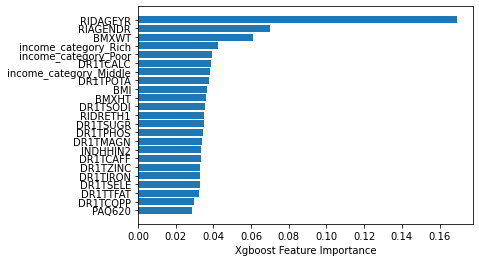

Selected features: ['income_category_Rich', 'BMXWT', 'RIAGENDR', 'RIDAGEYR']


In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


feature_names = X_train.columns

# Train the model
model = xgb.XGBClassifier(objective='multi:softprob', num_class=4)
model.fit(X_train, y_train)

# Feature importance
importances = model.feature_importances_
sorted_idx = importances.argsort()

# Plot feature importance
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

# Selecting features based on threshold
threshold = 0.04  # can be adjusted based on model insight
selected_features = [feature_names[i] for i in sorted_idx if importances[i] > threshold]
print("Selected features:", selected_features)


### Random Forest With CV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

## using GridSearchCV to find best max_features:
# grid_values = {'max_features': np.linspace(1,len(X_train.columns),len(X_train.columns), dtype='int32')}
grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5 ,10, 15],
               'n_estimators': [500, 1500, 2500]}


rf2 = RandomForestClassifier(random_state=42)

cv = KFold(n_splits=10,random_state=42,shuffle=True)
rf_cv = GridSearchCV(rf2, param_grid=grid_values, cv=cv)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int32),
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [500, 1500, 2500]})

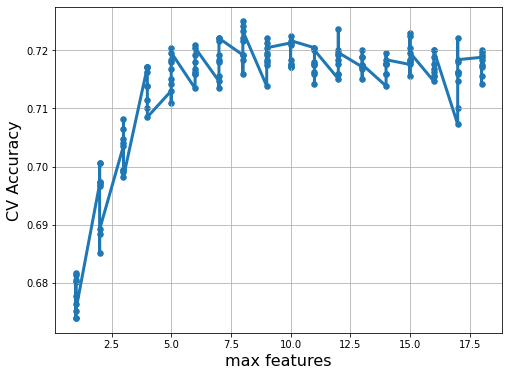

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')

In [ ]:
print(rf_cv.best_params_)

{'max_features': 8, 'min_samples_leaf': 15, 'n_estimators': 500}


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred_rf_cv = rf_cv.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred_rf_cv)
accuracy_log1 = accuracy_score (y_test, y_pred_rf_cv)
print ("Confusion Matrix : \n", cm1)
print("Accuracy Logistic Regression: \n", accuracy_log1)

Confusion Matrix : 
 [[607 112]
 [194 167]]
Accuracy Logistic Regression: 
 0.7166666666666667


### Gradient Boosting without CV

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


gbc = GradientBoostingClassifier(n_estimators=3000, max_leaf_nodes=15)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred_gbc)
accuracy_log1 = accuracy_score (y_test, y_pred_gbc)
print ("Confusion Matrix : \n", cm1)
print("Accuracy Logistic Regression: \n", accuracy_log1)

Confusion Matrix : 
 [[573 146]
 [192 169]]
Accuracy Logistic Regression: 
 0.687037037037037


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


gbc = GradientBoostingClassifier(n_estimators=3000, max_leaf_nodes=15)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred_gbc)
accuracy_log1 = accuracy_score (y_test, y_pred_gbc)
print ("Confusion Matrix : \n", cm1)
print("Accuracy Logistic Regression: \n", accuracy_log1)

In [ ]:
# Define the model
gbc = GradientBoostingClassifier(n_estimators=3000, max_leaf_nodes=15)


# Define the parameter grid
param_grid = {
    'max_depth': np.linspace(5,20,5, dtype='int32'),
    'learning_rate': np.linspace(0, 0.10, 21),
    'n_estimators': np.linspace(400,5000,2, dtype='int32'),
    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Test with best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 400}
Best cross-validation score: 0.72
Test Accuracy: 0.70


### Multi-class

In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Define the model
model = xgb.XGBClassifier(objective='multi:softprob')


# Define the parameter grid
param_grid = {
    'max_depth': np.linspace(5,20,5, dtype='int32'),
    'learning_rate': np.linspace(0, 0.10, 21),
    'n_estimators': np.linspace(400,5000,2, dtype='int32'),
    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Test with best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Fitting 5 folds for each of 525 candidates, totalling 2625 fits
Best parameters: {'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 500}
Best cross-validation score: 0.53
Test Accuracy: 0.50
